## Compare synthetic data with real data

In [2]:
import matplotlib.pyplot as plt
from torch.utils import data
import numpy as np
from tqdm import tqdm
import random
from functions import to_price_paths
from visualizationMetrics import visualization

### Step 1: Load real data

In [3]:
from dataLoader import *

In [4]:
real_data = load_dataset(data_mode='Test')
real_data_loader = data.DataLoader(real_data, batch_size=1, num_workers=1, shuffle=True)

[*********************100%%**********************]  1 of 1 completed
X_train's shape is (4840, 1, 1, 3), X_test's shape is (1213, 1, 1, 3)
y_train's label shape is (4840, 1, 1, 42), y_test's label shape is (1213, 1, 1, 42)


In [5]:
Y_test = real_data.Y_test.reshape(-1)
print(f"real ~ N({Y_test.mean()}, {Y_test.std()})")

real ~ N(0.0005328381084837019, 0.013412419706583023)


In [6]:
real_sims = []
real_conds = []

for i, (cond, sim) in enumerate(real_data_loader):
    sim = sim.cpu().detach().numpy()
    sim = sim.reshape(sim.shape[1], sim.shape[3])
    real_sims.append(sim)
    cond = cond.cpu().detach().numpy()
    cond = cond.reshape(cond.shape[1], cond.shape[3])
    real_conds.append(cond)
    # if label[0] == 0:
    #     real_running.append(sig)
    # elif label[0] == 1:
    #     real_jumping.append(sig)

real_sims = np.array(real_sims)
real_conds = np.array(real_conds)
print(real_sims.shape)
print(real_conds.shape)

(1213, 1, 42)
(1213, 1, 3)


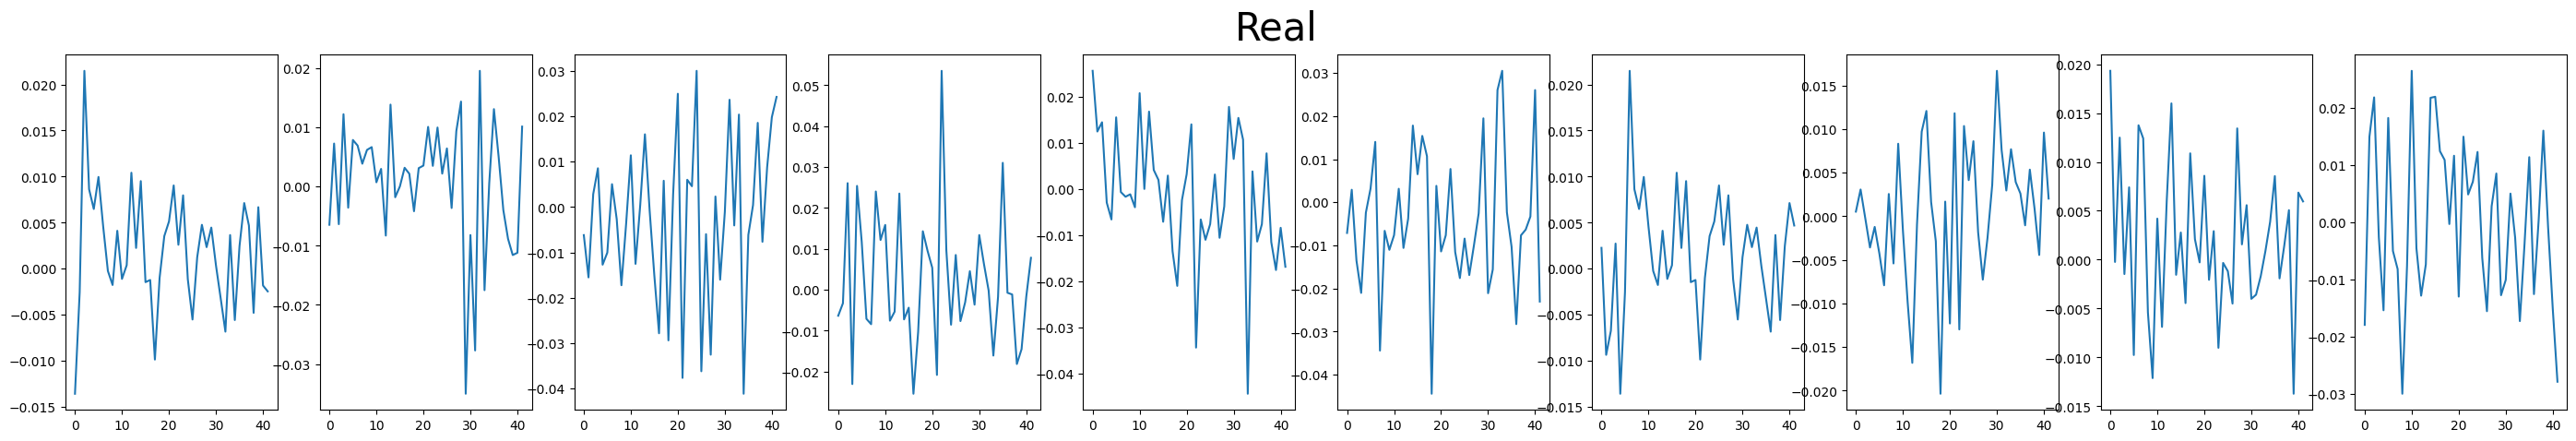

In [7]:
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('Real', fontsize=30)
for i in range(10):
    for sim_i_j in real_sims[i]:
        axs[i].plot(sim_i_j[:])

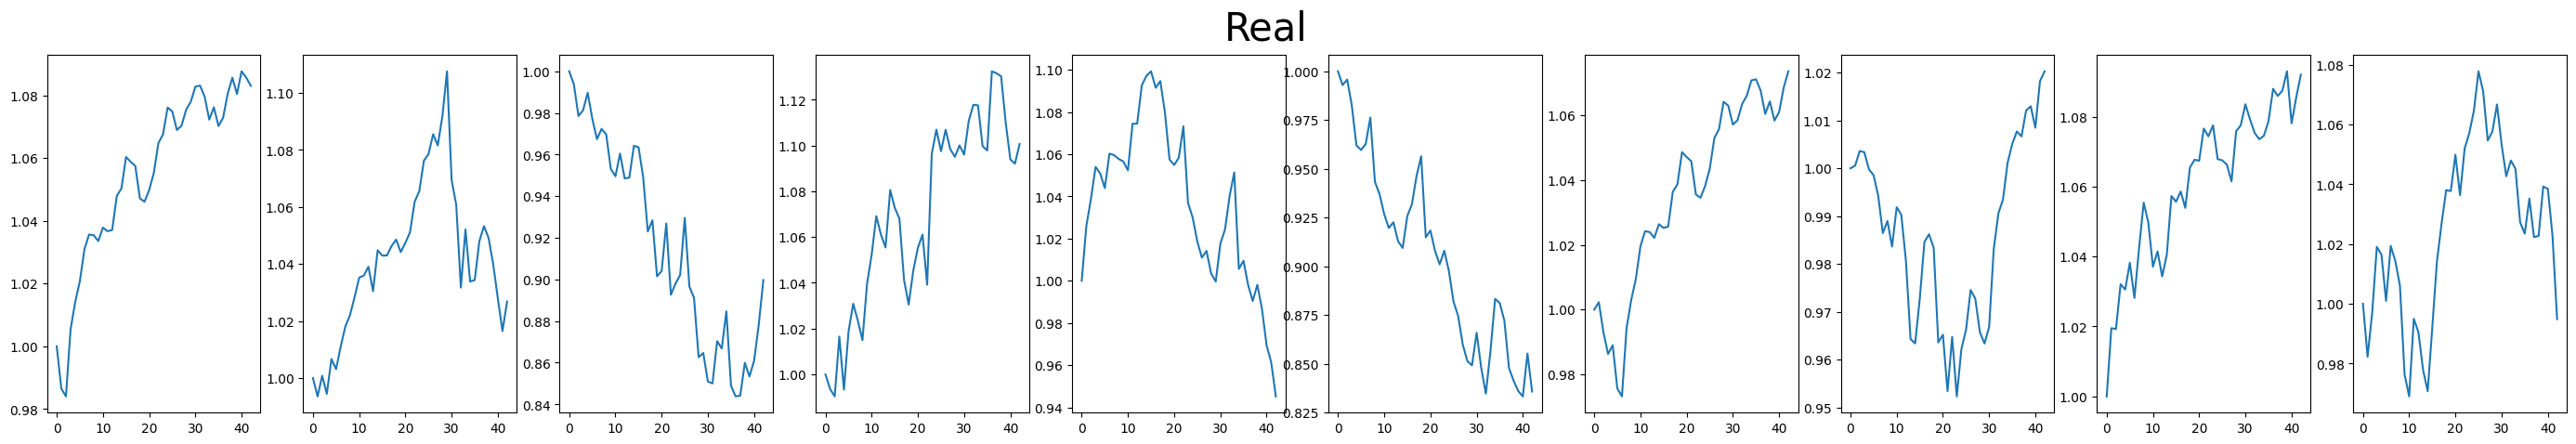

In [8]:
real_paths = to_price_paths(real_sims)

fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('Real', fontsize=30)
for i in range(10):
    for path_i_j in real_paths[i]:
        axs[i].plot(path_i_j[:])

### Step 2: Load synthetic data

In [35]:
from LoadSynthetic import *

In [36]:
syn_data = Synthetic_Dataset(model_path='./logs/Running_2024_03_31_10_21_36/Model/checkpoint', seq_len=real_data.output_size, conditions_dim=real_data.X_train.shape[-1])
syn_data_loader = data.DataLoader(syn_data, batch_size=1, num_workers=1, shuffle=True)

[*********************100%%**********************]  1 of 1 completed
X_train's shape is (4840, 1, 1, 3), X_test's shape is (1213, 1, 1, 3)
y_train's label shape is (4840, 1, 1, 42), y_test's label shape is (1213, 1, 1, 42)


In [37]:
syn_sims = []
syn_conds = []

for i, (cond, sim) in enumerate(syn_data_loader):
    sim = sim.cpu().detach().numpy()
    sim = sim.reshape(sim.shape[1], sim.shape[3])
    syn_sims.append(sim)
    cond = cond.cpu().detach().numpy()
    syn_conds.append(cond)
    
syn_sims = np.array(syn_sims)
syn_conds = np.array(syn_conds)
print(syn_sims.shape)
print(syn_conds.shape)

(4840, 1, 42)
(4840, 1, 3)


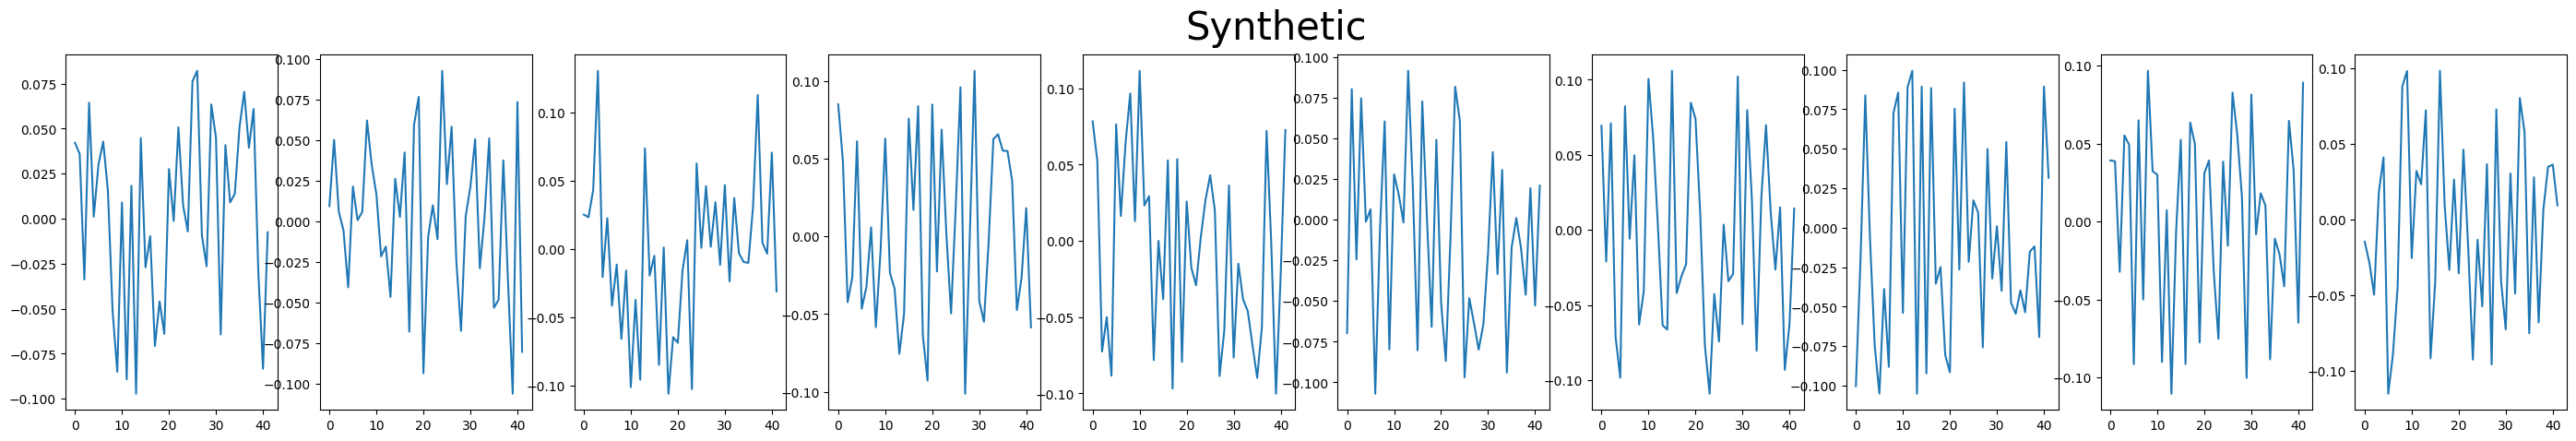

In [38]:
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('Synthetic', fontsize=30)
for i in range(10):
    for sim_i_j in syn_sims[i]:
        axs[i].plot(sim_i_j[:])

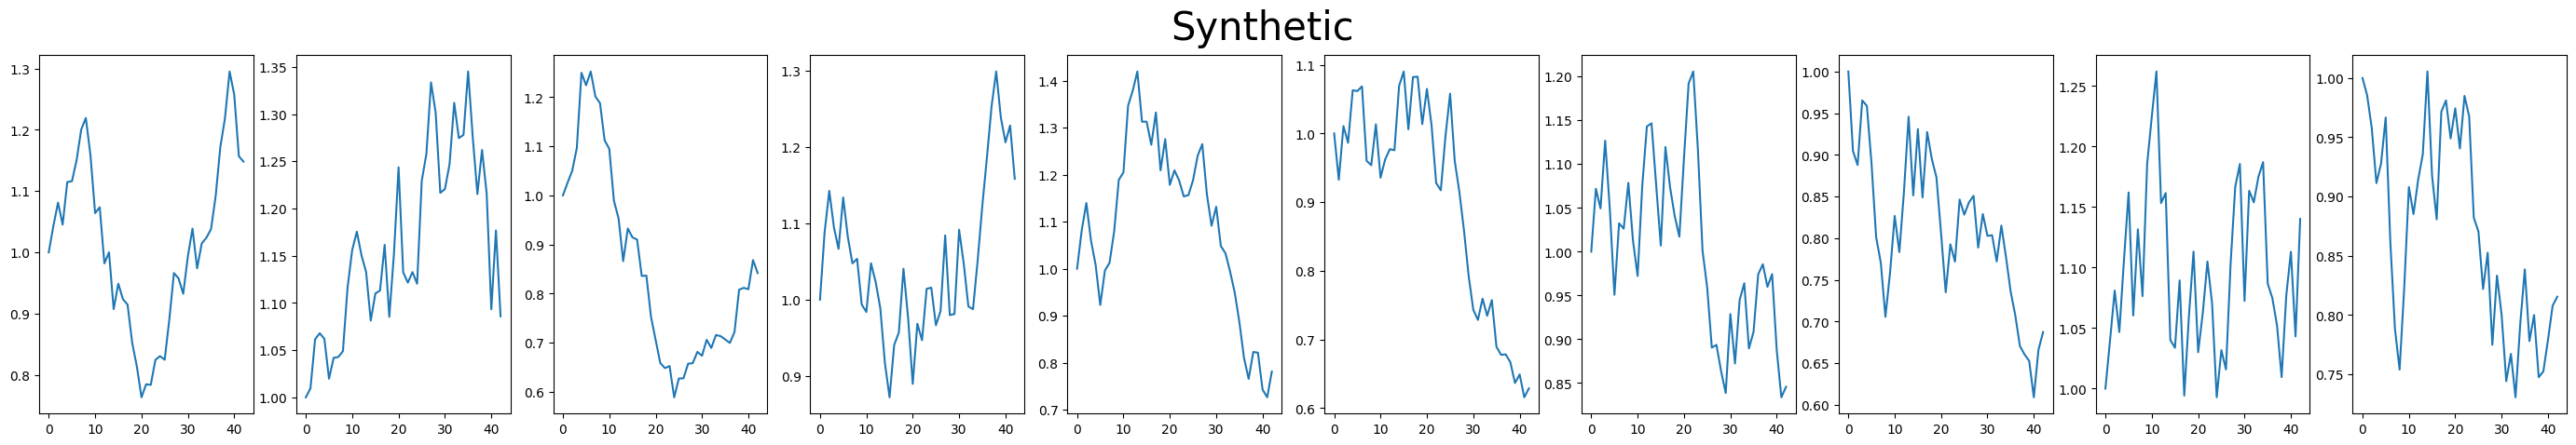

In [39]:
syn_paths = to_price_paths(syn_sims)

fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('Synthetic', fontsize=30)
for i in range(10):
    for path_i_j in syn_paths[i]:
        axs[i].plot(path_i_j[:])

### Step 3: PCA

In [48]:
real_vals = np.transpose(real_paths, (0,2,1)) #np.concatenate((real_conds, real_paths), axis=-1), (0,2,1))
syn_vals = np.transpose(syn_paths, (0,2,1)) #np.concatenate((syn_conds, syn_paths), axis=-1), (0,2,1))
# syn_vals = np.clip(syn_vals, a_max=8, a_min=-8)

print(real_vals.shape)
print(syn_vals.shape)

(1213, 43, 1)
(4840, 43, 1)


In [49]:
visualization(real_vals, syn_vals, 'pca', 'test')

In [50]:
visualization(real_vals, syn_vals, 'tsne', 'test')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.073905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.001770
[t-SNE] KL divergence after 300 iterations: 1.403810


## Compare synthetic data with monte-carlo simulations

In [51]:
class GBM_Simulator:
    def __init__(self, dataset, nsamples=500):
        self.Y = dataset.Y
        self.window = dataset.output_size
        self.train_size = len(dataset.Y_train)
        self.test_size = len(dataset.Y_test)
        self.nsamples = nsamples
    
    def empirical_martingale_correction(self, paths, r):
        """
        paths: 2d array/list of dimensions nsamples * nsteps
        r:     risk-free rate
        """
        old_paths = paths.copy()
        for j in range(1, paths.shape[1]):
            Zj = paths[:, j-1] * paths[:, j] / old_paths[:, j-1]
            Z0 = 1/len(paths) * np.exp(-r/252*j) * Zj.sum()
            paths[:, j] = paths[0][0] * Zj / Z0
        return paths
    
    def simulate(self, mu=0, var=0.1, s0=1, nsamples=100, nsteps=100, EMS=True):
        """
        Returns sample_paths, an np.array() of dimensions (nsamples * nsteps)
        """
        # For each sample
        init_path = np.zeros(nsteps + 1)
        init_path[0] = s0
        sample_paths = np.array([init_path for _ in range(nsamples)]) # nsamples * (nsteps+1)
        
        # Adjust drift terms
        nu = mu - var/2
        std = np.sqrt(var)
        # For each sample
        for sample in range(0, nsamples, 2):
            for nstep in range(nsteps):
                # Generate correlated random variables
                z = np.random.randn()
                # Get normal & antithetic steps
                step = nu + z*std
                antithetic_step = nu - z*std
                # Update the paths
                sample_paths[sample, nstep+1] = sample_paths[sample, nstep] * np.exp(step)
                sample_paths[sample+1, nstep+1] = sample_paths[sample+1, nstep] * np.exp(antithetic_step)
        # Empirical martingale correction
        if EMS: sample_paths = self.empirical_martingale_correction(sample_paths, r=mu)
        return sample_paths#[:,1:]

    def calibrate(self, logreturns, r=None, ivol=None):
        # Get drift
        mu = logreturns.mean() if r is None else r
        # Get variance
        var = logreturns.var() if ivol is None else ivol
        return mu, var
    
    def run(self, risk_neutral=True, implied_vol=True, EMS=True):
        simulations = np.zeros((self.test_size, self.nsamples, self.window+1))
        # For each window
        for i in tqdm(range(self.test_size-1), position=0, leave=True):
            mu, var = self.calibrate(self.Y[self.train_size-1 + i], r=None, ivol=None)
            # For each sample
            simulations[i,:,:] = self.simulate(mu, var, nsamples=self.nsamples, nsteps=self.window, EMS=EMS)
        return simulations

In [52]:
simulator = GBM_Simulator(dataset=real_data)
gbm_paths = simulator.run()
gbm_paths = np.reshape(gbm_paths, (-1,1,gbm_paths.shape[-1]))

print(gbm_paths.shape)

100%|██████████| 1212/1212 [01:55<00:00, 10.46it/s]


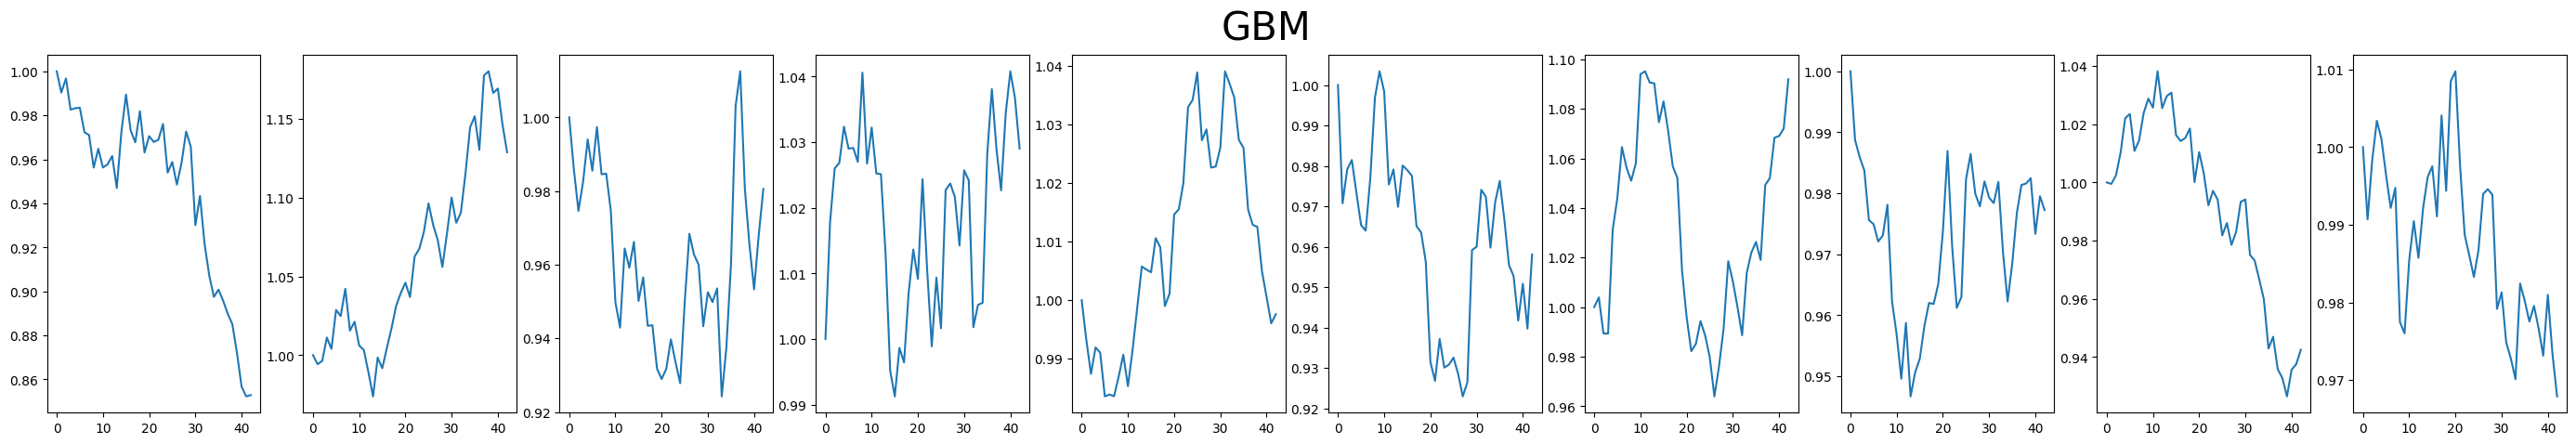

In [54]:
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('GBM', fontsize=30)
samples = random.sample(range(len(gbm_paths)),k=10)
for i in range(10):
    for sim_i_j in gbm_paths[samples[i]]:
        axs[i].plot(sim_i_j[:])

In [57]:
gbm_vals = np.transpose(gbm_paths, (0, 2, 1))

print(gbm_vals.shape)

(606500, 43, 1)


In [58]:
visualization(real_vals, gbm_vals, 'pca', 'test')

In [59]:
visualization(real_vals, gbm_vals, 'tsne', 'test')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.044627
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.830536
[t-SNE] KL divergence after 300 iterations: 1.492508
